In [1]:
import numpy as np
import scipy.fftpack as sci
from scipy import signal
import openpyxl as xl 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use(["ggplot"])
%matplotlib inline

In the following block the pressure and time readouts will be performed

In [2]:
wb = xl.load_workbook("AP_SPL.xlsx")
ws1 = wb["Time_series"]

'''
Functions that will extract data from the xlsx data and will conert them to numpy arrays.
'''

def timereadout(presscolumn):
    numm = 0 
    for cell in ws1[presscolumn]:
        if cell.value != None:
            numm += 1 
    time = np.zeros(numm-1)       
    for i, cell in enumerate(ws1['A']):
        if i != 0:
            if i == numm:
                break
            else:
                time[i-1] = cell.value
    return time  

def pressreadout(column):
    #print((ws1[column+ "1"]).value)
    numm = 0
    for cell in ws1[column]:
        if cell.value != None:
            numm += 1 
    pressval = np.zeros(numm-1)
    for p, cell2 in enumerate(ws1[column]):
        if p != 0:
            if p == numm:
                break
            else:
                pressval[p-1] = cell2.value
    return pressval    

Smoothening

In [3]:
def smooth(x):
    return signal.savgol_filter(x, 41, 5)

Matplotlib PSD transform

In [4]:
def plttransform(usepresscolumn):
    presss = pressreadout(usepresscolumn) #select the column with the preffered microphone
    #that why the column for timereadout is the same as pressreadout
    dt =512*0.00000009305
    N = 2**9
    
    # %matplotlib qt is NOT the proper way but it works!
    %matplotlib qt 
    readouts = plt.psd(presss, return_line = True, NFFT = N,  Fs = 1/(dt), noverlap = 256/2, window = np.hanning(N), scale_by_freq = False)
    %matplotlib inline
    
    pref = 20*(10**(-6))
    pxxplt = readouts[0]
    for o, px in enumerate(pxxplt):
        pxxplt[o] = 10*(np.log10(px/(pref**2))) 
    
    freqplt = readouts[1]
    return freqplt, pxxplt
    

In [5]:
def plotpltpsd(presscolumn):
    x, y = plttransform(presscolumn)
    plt.plot(x,y)
    #plt.plot(x, smooth(y), "-b", label = "Savitzky-Golay Smoothening fn.")
    plt.legend()
    plt.title("Matplotlib psd")
    plt.xlabel("Frequency")
    plt.ylabel("dB")
    plt.show()

In [6]:
    '''To plot dB vs STd'''
    def STdplot(x, y, presscolumn):
        d = 7/1000
        U = 100
        
        a, b = plttransform(presscolumn)
        STdplt = np.copy(a)
        for c, e in enumerate(STdplt):
            STdplt[c] = (e*d)/U
        
        STd = np.copy(x)
        for i, s in enumerate(STd):
            STd[i] = (s*d)/U

        plt.plot(STd, y, label = 'Scipy Welch')
        #plt.plot(STdplt, b, label = 'Matplotlib Psd')
        #plt.legend()
        plt.xlim(0.05, 0.6)
        plt.ylim(0, 140)
        plt.xlabel(r"$St_D$")
        plt.ylabel(r"$dB$")
        #plt.savefig('welch_320degnew.pdf')
        plt.show()
    

Christophers PSD

In [7]:
def Christophersdata(usepresscolumn):
    frequencies = []
    pxxvalues = []
    ws2 = wb["Freq_series"]
    for nrow, row in enumerate(ws2["A"]):
        if nrow != 0:
            frequencies.append(row.value)
    for nrow2, row2 in enumerate(ws2[usepresscolumn]):
        if nrow2 != 0:
            pxxvalues.append(row2.value)
    
    plt.plot(frequencies, pxxvalues)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("dB")
    plt.title("Results from Cristopher")
    plt.show()   

Welch Function

In [19]:
def welchplot(usepresscolumn):
    press = pressreadout(usepresscolumn)
    dt =512*0.00000009305
    N = 2**9
    pref = 20*(10**(-6))
    
    welchreadout = signal.welch(press, fs = (1/dt), window = "hanning", scaling = "spectrum", nperseg = 256, noverlap = 256/2, nfft = N)
    
    welchfreq = welchreadout[0]
    welchpxx = welchreadout[1]
    for i, px in enumerate(welchpxx):
        welchpxx[i] = 10*(np.log10(px/pref**2))
    
     '''
    plt.plot(welchfreq, welchpxx)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("dB")
    plt.title("Welch psd 300 deg")
    plt.show()
    '''
    STdplot(welchfreq, welchpxx, usepresscolumn)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 14)

No handles with labels found to put in legend.


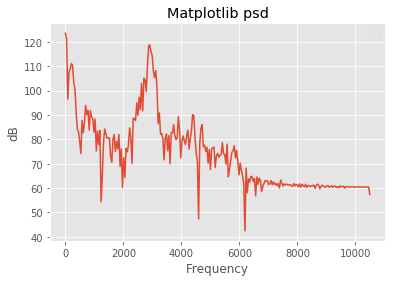

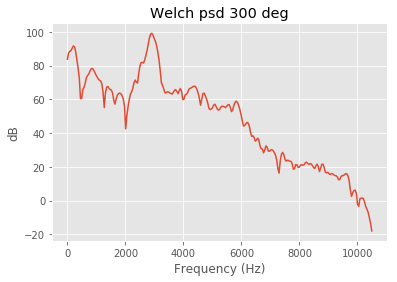

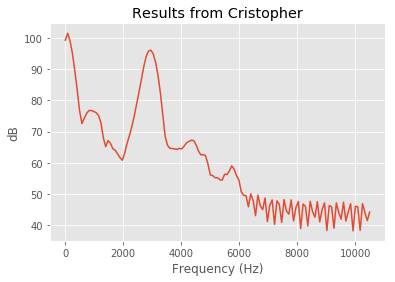

In [20]:
plotpltpsd("K")
welchplot("K")
Christophersdata("K")

The Welch function looks good, Christophers results are based on a different free stream velocity. Remember from which and until which frequency the data is reliable, some sort of theorem that says that half the sampling freq is max "Nyquist-frequency". Check lowest frequency, if you have a 1 second of messurements the lowest frequency one can measure is 1 Herz. An other idea is to compare matplotlib psd with welch psd. And then finally plot the data between the lowest and highest frequency as function of the Strouhal number STd. 

The cell with freq. 2951.72..... equals 72, thus 0,1,2,...,72.
The cell below calculates the magnitude of the sound in dB at the frequency of 2951.72

In [125]:
def directionalplot(listoffreqreq): 
    aaa = 0
    for numm in listoffreqreq:
        excelcols = ["B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","AA","AB","AC","AD","AE","AF"]
        decibel = []
        dt =512*0.00000009305
        N = 2**9
        pref = 20*(10**(-6))
        theta = np.arange((-150*np.pi)/180, (160*np.pi)/180, (10*np.pi)/180)

        for col in excelcols:
            freqq, deci =  signal.welch(pressreadout(col), fs = (1/dt), window = "hanning", scaling = "spectrum", nperseg = 256, noverlap = 256/2, nfft = N)
            for i, px in enumerate(deci):
                deci[i] = 10*(np.log10(px/pref**2))
            decibel.append(deci[numm]) 
            if numm == 70:
                print(deci[numm])
            
        
        labelstr = [ r'$St_D$ 0.1', r'$St_D$ 0.2', r'$St_D$ 0.3', r'$St_D$ 0.4']
        
        plt.polar(theta,decibel,'-', marker='.', label = labelstr[aaa])
        aaa += 1
        
        
        
        #plt.title("Noise intensity at 2951.72 Hz (base freq.)")
    
    plt.legend(framealpha = 0.4, loc = 2)
    plt.savefig('directionalnew.pdf')
    plt.show()

97.80819823601126
103.20263932205167
105.87181414677944
105.3139718681264
107.21325415571975
108.18079018811444
111.30498788693967
114.23580908449766
117.31460396591395
119.69423265571311
120.57724322628546
117.5029789068847
107.69901899963706
105.41497925588021
95.69665735978802
89.5240210381907
76.38620638460466
99.1385951489089
99.04026063707194
109.75477476361297
113.9800574091932
109.1940416333283
102.7316704153564
93.63337544047069
83.31127403816446
90.31154439842297
88.10523156491463
83.24858223163666
80.20831975332852
85.88596483365528
89.18670052366821


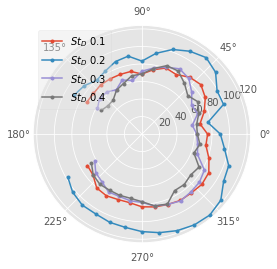

In [126]:
directionalplot([35, 70, 105, 139])